In [1]:
import numpy as np
import crispr_assembler as ca
import matplotlib.pyplot as plt
import editdistance as ed
import os
import pickle


%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
def get_weights(gr, arrays):
    weights = []
    for a in arrays:
        w = []
        for x, y in zip(a, a[1:]):
            w.append(gr[x, y])
        weights.append(w)
    
    return weights

In [5]:
def get_routes(graph, route, routes, vertex):
    candidates = np.where(graph[vertex] > 0)[0]
    #print(candidates)
    if len(candidates) == 0:
        #print("a", routes)
        routes.append(route)
    else:
        is_final = 1
        for candidate in candidates:
            if not candidate in route:
                is_final = 0
                new_route = [x for x in route]
                new_route.append(candidate)
                #print('n', new_route)
                get_routes(graph, new_route, routes,candidate)
        if is_final:
            #print("a", routes)
            routes.append(route)

In [6]:
def restore_all(graph):
    start_vertexes = np.where(graph.sum(0) == 0)[0]
    
    answ = []
    
    for vertex in start_vertexes:
        routes = []
        route = [vertex]
        get_routes(graph, route, routes, vertex)
        
        answ.extend(routes)
        
    return answ

In [7]:
def make_vertexes_embs(gr):
    embs = np.zeros((gr.flatten().shape[0], 5))
    
    for i in range(embs.shape[0]):
        x, y = i // gr.shape[0], i % gr.shape[0]
        #print(x, y)
        embs[i, 0] = gr[x, y]
        embs[i, 1] = embs[i, 0] /  max(1, gr[x].sum())
        embs[i, 2] = embs[i, 0] /  max(1,gr[:, y].sum())
        
        embs[i, 3] = embs[i, 0] / max(1, gr[:, x].sum())
        embs[i, 4] = embs[i, 0] / max(1, gr[y].sum())
    return embs

In [8]:
def calc_metrics_2(gr, gr_r, a):
    spacers = np.array(sorted(list(set([x for x in range(gr_r.shape[0])] + ca.unwrap_nested(a)))))

    reference_gr = (ca.graph_from_arrays(a, len(spacers))[0] > 0).astype(int)
    restored_gr = gr_r[spacers][:, spacers]#(ca.graph_from_arrays(r, len(spacers))[0] > 0).astype(int)
    
    return roc_auc_score(reference_gr.flatten(), restored_gr.flatten()), \
            f1_score(reference_gr.flatten(), restored_gr.flatten()), \
            precision_score(reference_gr.flatten(), restored_gr.flatten()), \
            recall_score(reference_gr.flatten(), restored_gr.flatten())
            
            
    

In [9]:
def do_all_2(f_name, res, answ):
    gr = res.graph_from_pairs()[0]
    embs= make_vertexes_embs(gr.astype(float))
    pred = gb.predict(embs[:, 1:]).reshape(gr.shape)
    print(f_name)
    #r, w = ca.restore_arrays(res[1][0], 5)
    a, d = ca.multiple_arrays_to_ids(answ, res.spacer_to_cluster_index)
    
    print(" & ".join(map(lambda x : "{0:.3f}".format(x), calc_metrics_2(gr, pred, [x for x in a.values()]))))
    
    return pred
    #return r, w, a, d, calc_metrics(res[1][0], r, [x for x in a.values()])

In [11]:
answer_sensivity = ca.read_arrays_with_tags("./79_answ", 0)

2,3,5,7,8,11,14,15,21,22

strain 14 = 2 ng/ul
strain 7 = 1 ng/ul
strain 3 = 0.5 ng/ul
strain 5 = 0.25 ng/ul
strain 22 = 0.125 ng/ul
strain 15 = 0.0625 ng/ul
strain 21 = 0.031 ng/ul
strain 2 = 0.015 ng/ul
strain 8 = 0.007 ng/ul
strain 11 = 0.003 ng/ul

# Calc answ

In [12]:
def restore(path, minimum_occurences = 0):
    read = ca.Read(path)
    read.correct_errors(minimum_occurences = minimum_occurences)
    #gr = read.graph_from_pairs()

    return read#, gr

In [14]:
path = '/home/anton/BigMac/skoltech/CRISPR_research/data/clostr_11_12/out/pairs/79/'
files = sorted(os.listdir(path))

In [15]:
files

['CDisolate79_S12_L001_R1_001.fastq.gz_pairs.txt',
 'CDisolate79_S12_L001_R2_001.fastq.gz_pairs.txt',
 'merge.fastq']

In [16]:
sorted(files)[0:]

['CDisolate79_S12_L001_R1_001.fastq.gz_pairs.txt',
 'CDisolate79_S12_L001_R2_001.fastq.gz_pairs.txt',
 'merge.fastq']

In [17]:
res = restore(path + sorted(files)[0], 5) 

100%|██████████| 111/111 [00:00<00:00, 7823.88it/s]


In [18]:
a, d = ca.multiple_arrays_to_ids(answer_sensivity, res.spacer_to_cluster_index)

100%|██████████| 11/11 [00:00<00:00, 453.64it/s]


In [19]:
a_f = {}

for k,v in a.items():
    if np.median(d[k]) < 3:
        a_f[k] = v

In [20]:
a = a_f

In [21]:
gb = pickle.load(open("../gb_model", "rb"))

In [22]:
gr = res.graph_from_pairs()[0]

In [23]:
embs = make_vertexes_embs(gr)

In [24]:
answ_gr = ca.graph_from_arrays([x for x in a.values()], 500)[0]

In [25]:
graph_restored = gb.predict(embs[:, 1:]).reshape(gr.shape)

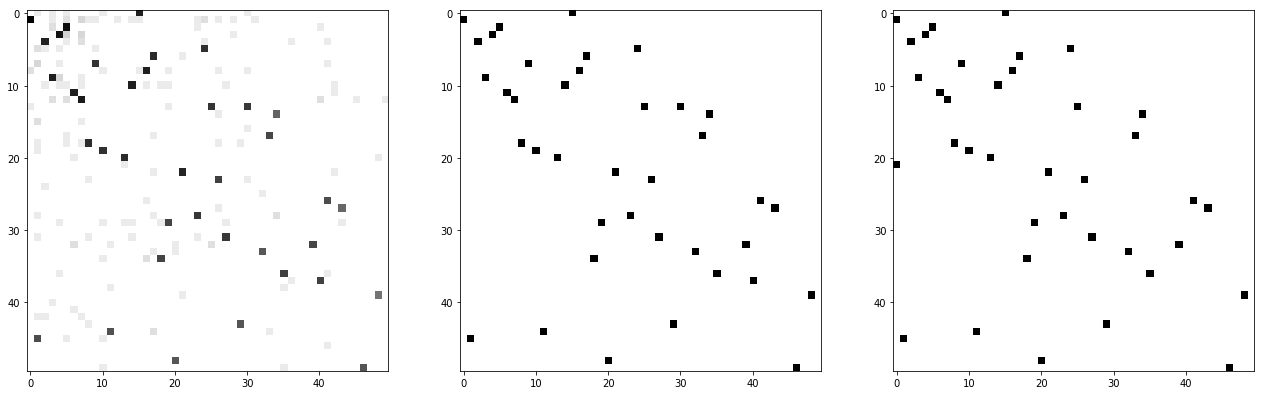

In [29]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2].astype(int),
            graph_restored[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 22)

In [220]:
restored_arrays = [x for x in restore_all(graph_restored) if len(x) > 1]
weights = get_weights(gr, restored_arrays)

In [186]:
# for ra,wa  in zip(restored_arrays, weights):
#     print(ra)
#     print(wa)
#     print("--------------------------------------------")

In [223]:
restored_gr_filtered = ca.graph_from_arrays(restored_arrays, 500)[0]

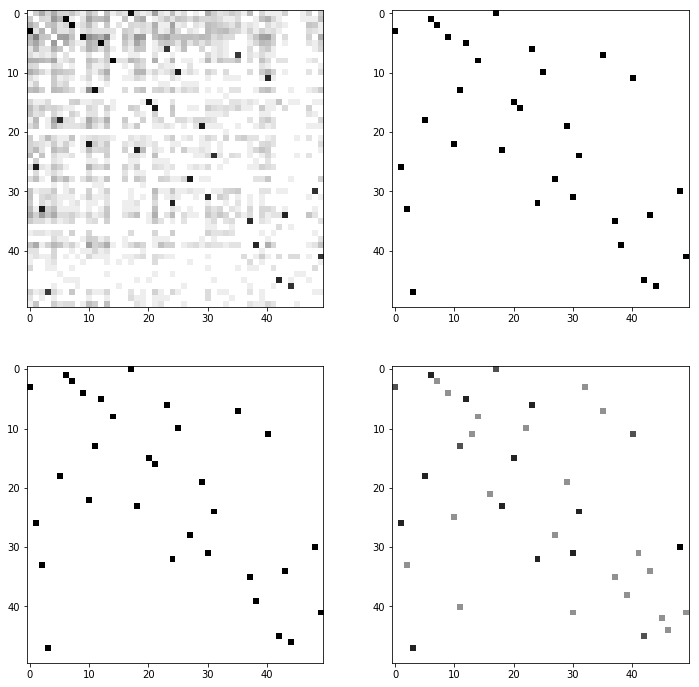

In [224]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2],
            graph_restored[c1:c2, c1:c2],
            restored_gr_filtered[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 12, 
            subplots_form = (2,2))

In [225]:
restored_arrays_filtered_dict = dict(zip(np.arange(len(restored_arrays)), restored_arrays))

In [226]:
def search_ays_in_b(a, b, gr):
    res = []
    for a_name, a_array in a.items():
        matched_parts, b_name, positions = ca.search_best_alignment(
            a_array,
            b)

        res.append(ca.Match(a_name,
             b_name,
             len(matched_parts[0]) / len(a_array),
             len(matched_parts[1]) / len(b[b_name]),
             a_array,
             b[b_name],
             get_weights(gr, [a_array]),
             get_weights(gr, [b[b_name]])))
        
        res[-1].print()
    
    return res

In [229]:
restored_arrays

[[28, 27, 111],
 [33, 2, 7, 35, 37, 77, 170],
 [39, 38, 83, 93, 54, 74, 143, 156],
 [58, 13, 11, 40, 133],
 [62, 16, 21],
 [71, 15, 20],
 [85, 47, 3, 0, 17, 113, 152, 78, 32, 24, 31, 30, 48, 116, 168],
 [91, 89, 117, 87, 95, 140, 124, 112],
 [101, 99],
 [105, 22, 10, 25, 80, 70, 96, 133],
 [106, 46, 44, 73, 109, 127, 149, 160],
 [128, 90, 26, 1, 6, 23, 18, 5, 12, 131, 164],
 [129, 103, 98],
 [136, 94, 100, 150],
 [137, 110],
 [141, 142],
 [146, 145],
 [147, 82, 50, 53, 63, 97, 61, 59, 107, 69, 79, 135],
 [148, 67, 8, 14],
 [151, 102, 64, 86, 144, 138, 126, 125, 114, 118],
 [153, 104, 51, 41, 49, 88, 66, 57, 92, 75, 84],
 [153, 104, 51, 41, 81, 122],
 [155, 154],
 [158, 108, 34, 43],
 [159, 123, 119, 120, 121],
 [161, 157],
 [163, 139, 72, 4, 9, 52, 19, 29],
 [165, 45, 42, 134],
 [166, 162, 65, 36, 55],
 [171, 130, 68, 56, 60, 76, 115, 132]]

In [228]:
comp_log = search_ays_in_b(a, restored_arrays_filtered_dict, gr)

searched name: 77_4
 found name: 28
 searched_overlap: 0.6666666666666666
 found_overlap: 1.0
 arrs (search, found): 
[38, 166, 65, 36, 55, 76]
[166, 162, 65, 36, 55]
 weights (search, found):
[[0, 0, 3051, 3569, 0]]
[[11, 31, 3051, 3569]]
 _____________________

searched name: 79_3 (20/22)
 found name: 17
 searched_overlap: 0.6
 found_overlap: 1.0
 arrs (search, found): 
[147, 140, 22, 55, 82, 50, 53, 63, 97, 61, 59, 107, 69, 79, 135, 58, 13, 11, 40, 133]
[147, 82, 50, 53, 63, 97, 61, 59, 107, 69, 79, 135]
 weights (search, found):
[[0, 1, 0, 0, 1940, 1802, 1688, 1146, 329, 2644, 516, 548, 2051, 143, 148, 3136, 13881, 5546, 126]]
[[169, 1940, 1802, 1688, 1146, 329, 2644, 516, 548, 2051, 143]]
 _____________________

searched name: 79_1
 found name: 29
 searched_overlap: 0.6428571428571429
 found_overlap: 1.0
 arrs (search, found): 
[11, 171, 130, 68, 56, 60, 76, 115, 132, 137, 110, 41, 81, 122]
[171, 130, 68, 56, 60, 76, 115, 132]
 weights (search, found):
[[0, 5, 446, 2513, 978, 2121

searched name: NC_009089_11
 found name: 29
 searched_overlap: 0.6428571428571429
 found_overlap: 1.0
 arrs (search, found): 
[122, 81, 41, 110, 137, 132, 115, 76, 60, 56, 68, 130, 171, 11]
[171, 130, 68, 56, 60, 76, 115, 132]
 weights (search, found):
[[0, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0]]
[[5, 446, 2513, 978, 2121, 325, 406]]
 _____________________

searched name: NC_009089_12
 found name: 13
 searched_overlap: 0.8333333333333334
 found_overlap: 1.0
 arrs (search, found): 
[150, 100, 94, 136, 99, 101]
[136, 94, 100, 150]
 weights (search, found):
[[0, 0, 0, 0, 0]]
[[294, 1343, 148]]
 _____________________

searched name: NC_009089_15
 found name: 4
 searched_overlap: 1.0
 found_overlap: 1.0
 arrs (search, found): 
[21, 16, 62]
[62, 16, 21]
 weights (search, found):
[[0, 1]]
[[2631, 11233]]
 _____________________

searched name: NC_009089_16
 found name: 27
 searched_overlap: 0.8333333333333334
 found_overlap: 1.0
 arrs (search, found): 
[134, 42, 45, 165, 142, 141]
[165, 45, 42, 1

In [193]:
d

{'648_5': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  17,
  16],
 '648_2': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 '648_3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  17],
 '648_6 (10/13)': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 '648_7': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0],
 '648_6 (2/3(13))': [0, 0],
 '648_Quastionable': [],
 '648_1': [16, 17, 25, 27, 17, 17, 17, 17],
 '648_4': [15,
  14,
  16,
  16,
  15,
  14,
  17,
  17,
  16,
  17,
  16,
  16,
  15,
  15,
  15,
  15,
  15,
  14,
  15,
  16,
  15,
  15,
  15,
  15,
  15,
  14,
  16,
  15,
  16,
  17,
  15,
  15,
  15,
  14,
  14,
  14,
  13,
  13,
  16]}

In [110]:
','.join([res.corrector.index_to_cluster[x] for x in [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9]])

'ACATGAATGTCGGTTCAGACCGTGTTTTT,AGTGCTGGACCATTTCAAATTCACAATAG,GGAATGATATTTCAATAAATAATTATAAC,TTTTTGTTAATTGCGTTTGCCACGGTTTG,TGAGCGTCGGCGGCTCGCTGGATTTGCG,AATGCATCAGTTGAACACAAAAGTAGCTT,TTTTGCTGACACCGGCAATACTGAACGGC,ACGGATTGCGGTATATGCAGTGTCCAGAT,TAAACCACCAGCCAGACCACCAATTACCA,GGGGATAACGGTTATCCACTGGCCGCCGA,TGTAATAGCCTGATCTCTGATCTCCCTCG,CTGTCCCAGGCCGAGGCTGTATTTCAATCC,GCGATGGATCAGGGTATTACACTCGACGG,GCTGCGGGTCAATCAACTGGAGTGCAAATC,GTCGCGCGCCGACGGAATAAACCGAATAA,TCGTCAGGGCACAATAACTGAGGTTCGCA,AGCAACGCGTAAACCAGATCGCCGATCGTG'

In [57]:
for key in a.keys():
    print(key, a[key])
    print(search_ays_in_b(a[key], restored_arrays_filtered_dict))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


AttributeError: module 'crispr_assembler' has no attribute 'search_ays_in_b'

In [58]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


NameError: name 'restored' is not defined

In [36]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]
(([127, 79, 67, 81, 64], [127, 79, 67, 77, 81, 64]), 47, (0, 5, 0, 6))
_____________________________________
first_2 [85, 197, 163, 95, 93]
(([85, 197, 163, 95, 93], [197, 163, 95, 93]), 48, (0, 5, 0, 4))
_____________________________________
first_3 [95, 93, 82, 84, 91, 115, 117]
(([95, 93, 82, 84, 91, 115, 117], [163, 95, 93, 82, 84, 91, 115, 117]), 48, (0, 7, 1, 9))
_____________________________________
first_5 [86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80]
(([86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80], [31, 35, 49, 56, 50, 48, 58, 73, 76, 80]), 18, (0, 11, 0, 10))
_____________________________________
first_7 [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]
(([85, 109, 112, 143, 144, 141, 139, 155, 170, 180], [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]), 41, (0, 10, 0, 10))
_____________________________________
first_8 [86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191]
(([35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [56, 50, 48, 58, 73, 

In [113]:
ca.dict_to_csv(ca.revert_dict(res.cluster_to_index), "./sensitivity_idx_to_sp")

In [121]:
with open("./sensitivity_restored", 'w') as f:
    for k,v in restored_arrays_filtered_dict.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join([ca.revert_dict(res.cluster_to_index)[x] for x in v]))
        f.write("\n")

In [125]:
with open("./sensitivity_answer", 'w') as f:
    for k,v in answer_sensivity.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join(v))
        f.write("\n")

In [124]:
answer_sensivity

{'first_11': ['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
  'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
  'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
  'CTAATGAGTCAGTTTGAACAGATCCCCGACAA',
  'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
  'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
  'GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG'],
 'first_2': ['TCTAAGTGATATCCATCATCGCATCCAGTGCGCC',
  'TCTTACTGCTTGGTATGCGGAATCACACCCTGAA',
  'ACTGAAGCATCAAACATTTGGTGGACCAAACGGA',
  'ACTGTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'ACGGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC'],
 'first_3': ['GTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC',
  'ACGCCAGCCACCTGCTTCGCCAGCCGTTCGG',
  'CACGGTAGCGCCACTGCGCGTCGGTGACGGG',
  'ACGAACAGGGATTTGTCGGCAGTTTCTTTAC',
  'TAATTCGCAAATCAATATATATTTTGTCCGT',
  'ATTGCGGATGCTCCCGGAATTGCGCGGGCAA'],
 'first_5': ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
  'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
  'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
  'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
  'ATCGTCCATATTAACAATCGTGGTGAGTTCAA',
  'ACTATGGCCCCGGCAAAAAACGCGCTGGTGGG'

In [114]:
res.dump("./sensitivity_res")

In [ ]:
ca.Comparator(restored, a, sp_to_id)

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

## True arrays

In [26]:
gr = res[0].graph_from_pairs()[0]

first_11


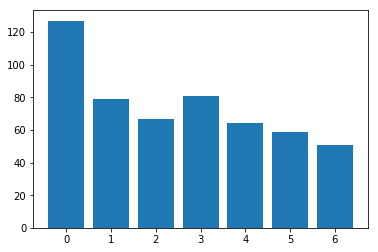

first_2


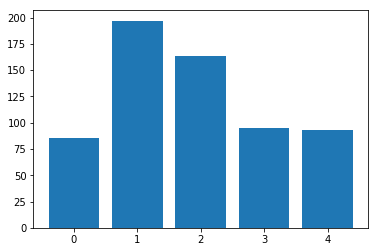

first_3


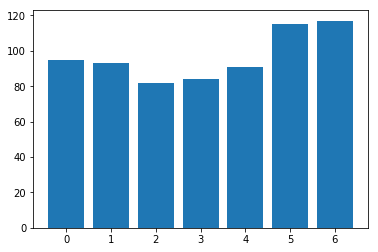

first_5


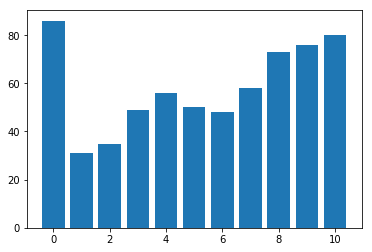

first_7


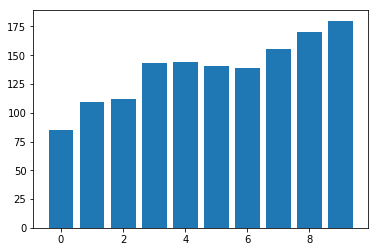

first_8


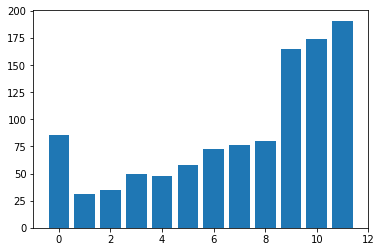

first_14


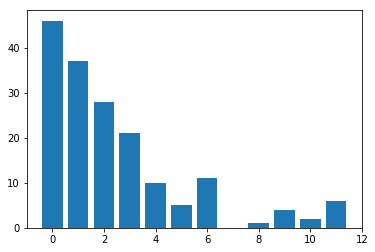

first_15


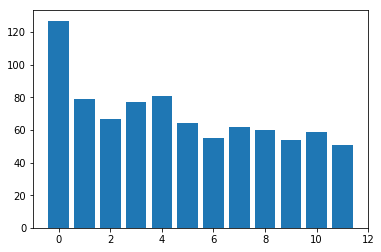

first_22


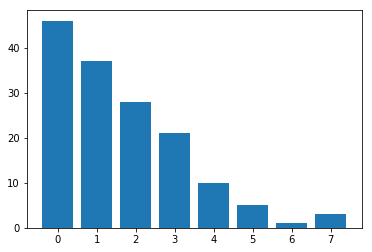

first_21


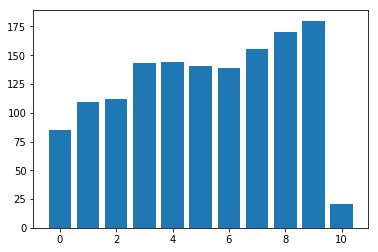

second_2


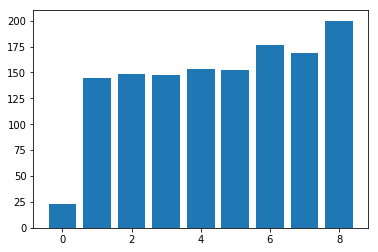

second_5


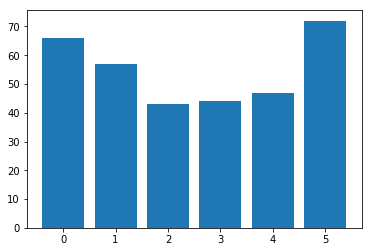

second_21


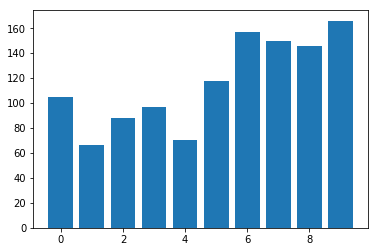

second_3


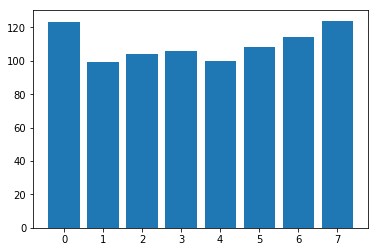

second_7


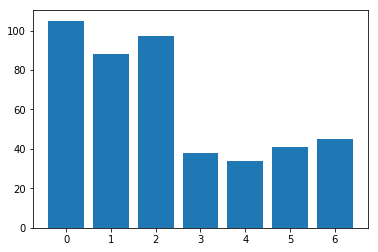

second_8


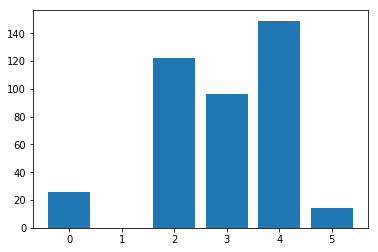

second_11


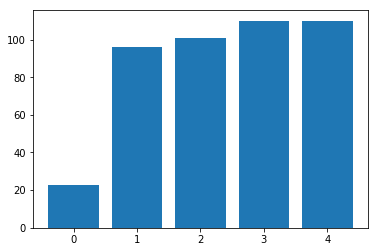

second_14


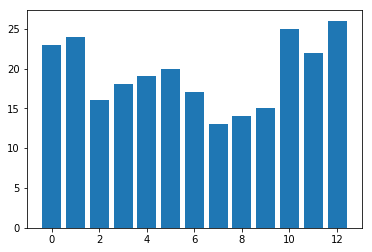

second_15


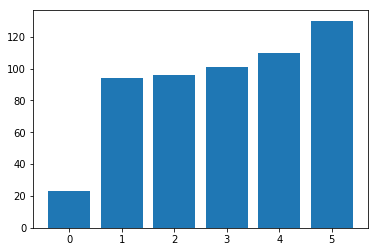

second_22


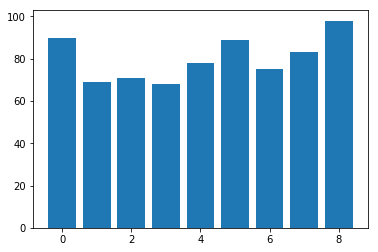

In [18]:
for key, arr in a.items():
    print(key)
    plt.bar(np.arange(len(arr)), arr)
    plt.show()

first_11


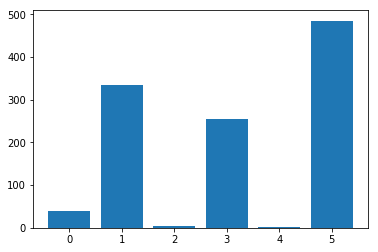

first_2


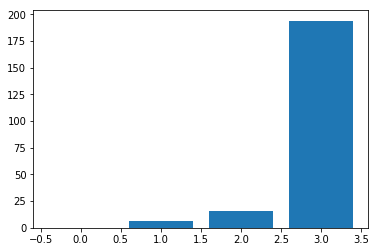

first_3


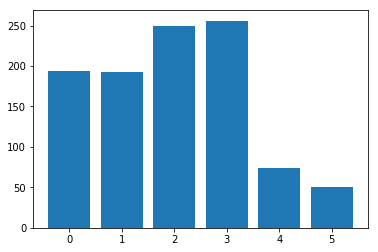

first_5


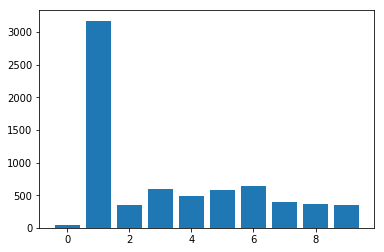

first_7


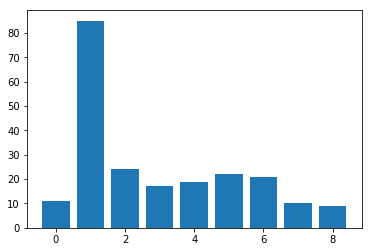

first_8


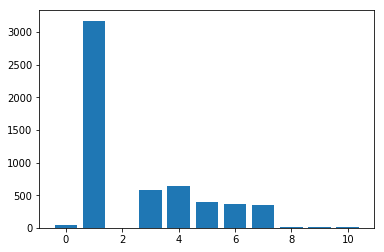

first_14


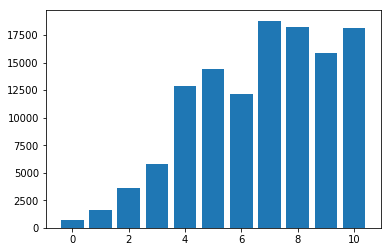

first_15


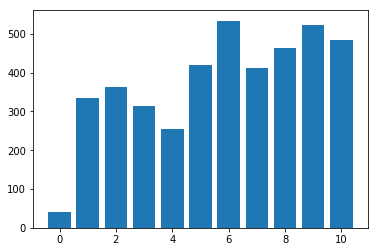

first_22


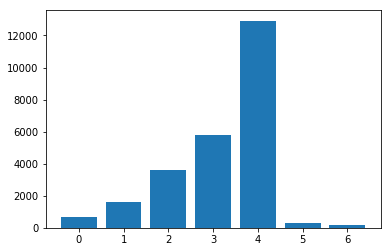

first_21


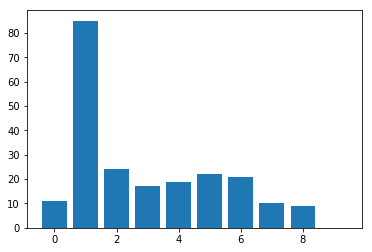

second_2


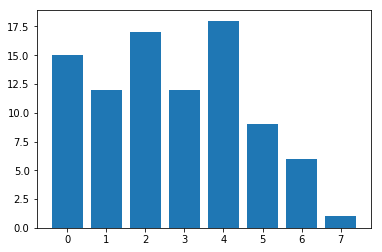

second_5


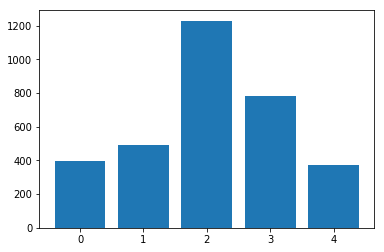

second_21


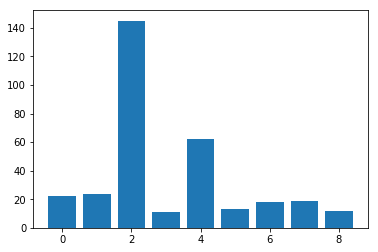

second_3


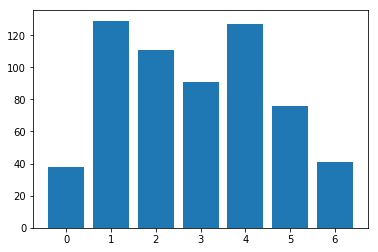

second_7


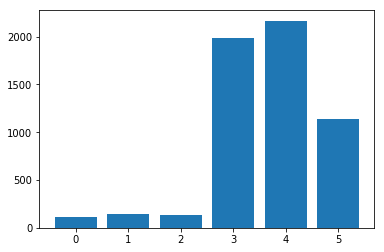

second_8


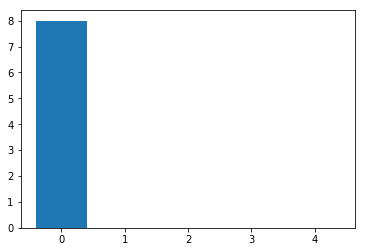

second_11


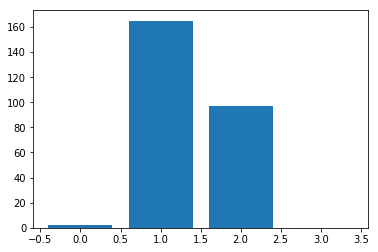

second_14


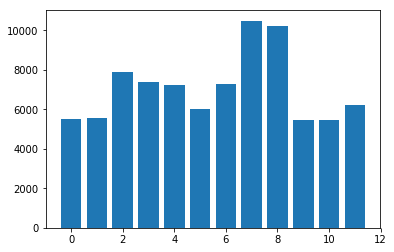

second_15


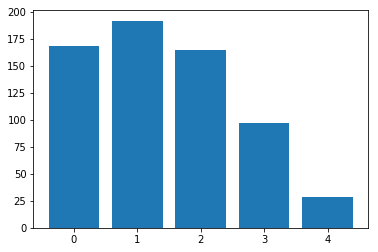

second_22


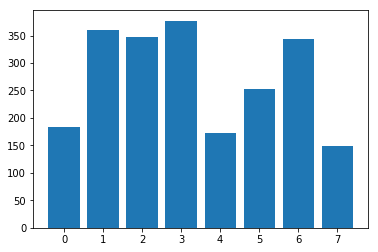

In [27]:
for key, arr in a.items():
    print(key)
    w = []
    for x,y in zip(arr, arr[1:]):
        w.append(gr[x, y])
        
    plt.bar(np.arange(len(w)), w)
    plt.show()

In [22]:
arr

[127, 79, 67, 81, 64, 59, 51]

In [25]:
strain 14 = 2 ng/ul
strain 7 = 1 ng/ul
strain 3 = 0.5 ng/ul
strain 5 = 0.25 ng/ul
strain 22 = 0.125 ng/ul
strain 15 = 0.0625 ng/ul
strain 21 = 0.031 ng/ul
strain 2 = 0.015 ng/ul
strain 8 = 0.007 ng/ul
strain 11 = 0.003 ng/ul

IndexError: tuple index out of range

In [30]:
for key, arr in a.items():
    print(key, np.median(arr))# np.median(sorted(arr)[1:-1]))
#     w = []
#     for x,y in zip(arr, arr[1:]):
#         w.append(gr[x, y])
        
#     plt.bar(np.arange(len(w)), w)
#     plt.show()

first_11 67.0
first_2 95.0
first_3 93.0
first_5 56.0
first_7 142.0
first_8 74.5
first_14 8.0
first_15 63.0
first_22 15.5
first_21 141.0
second_2 152.0
second_5 52.0
second_21 111.5
second_3 107.0
second_7 45.0
second_8 61.0
second_11 101.0
second_14 19.0
second_15 98.5
second_22 78.0


## EVal

In [27]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [29]:
restored_gr_filtered.shape

(500, 500)

In [30]:
answ_gr.shape

(500, 500)

In [31]:
gr.shape

(204, 204)

In [41]:
f1_score((answ_gr > 0).astype(int).flatten(), (restored_gr_filtered > 0).astype(int).flatten())

0.8353413654618473

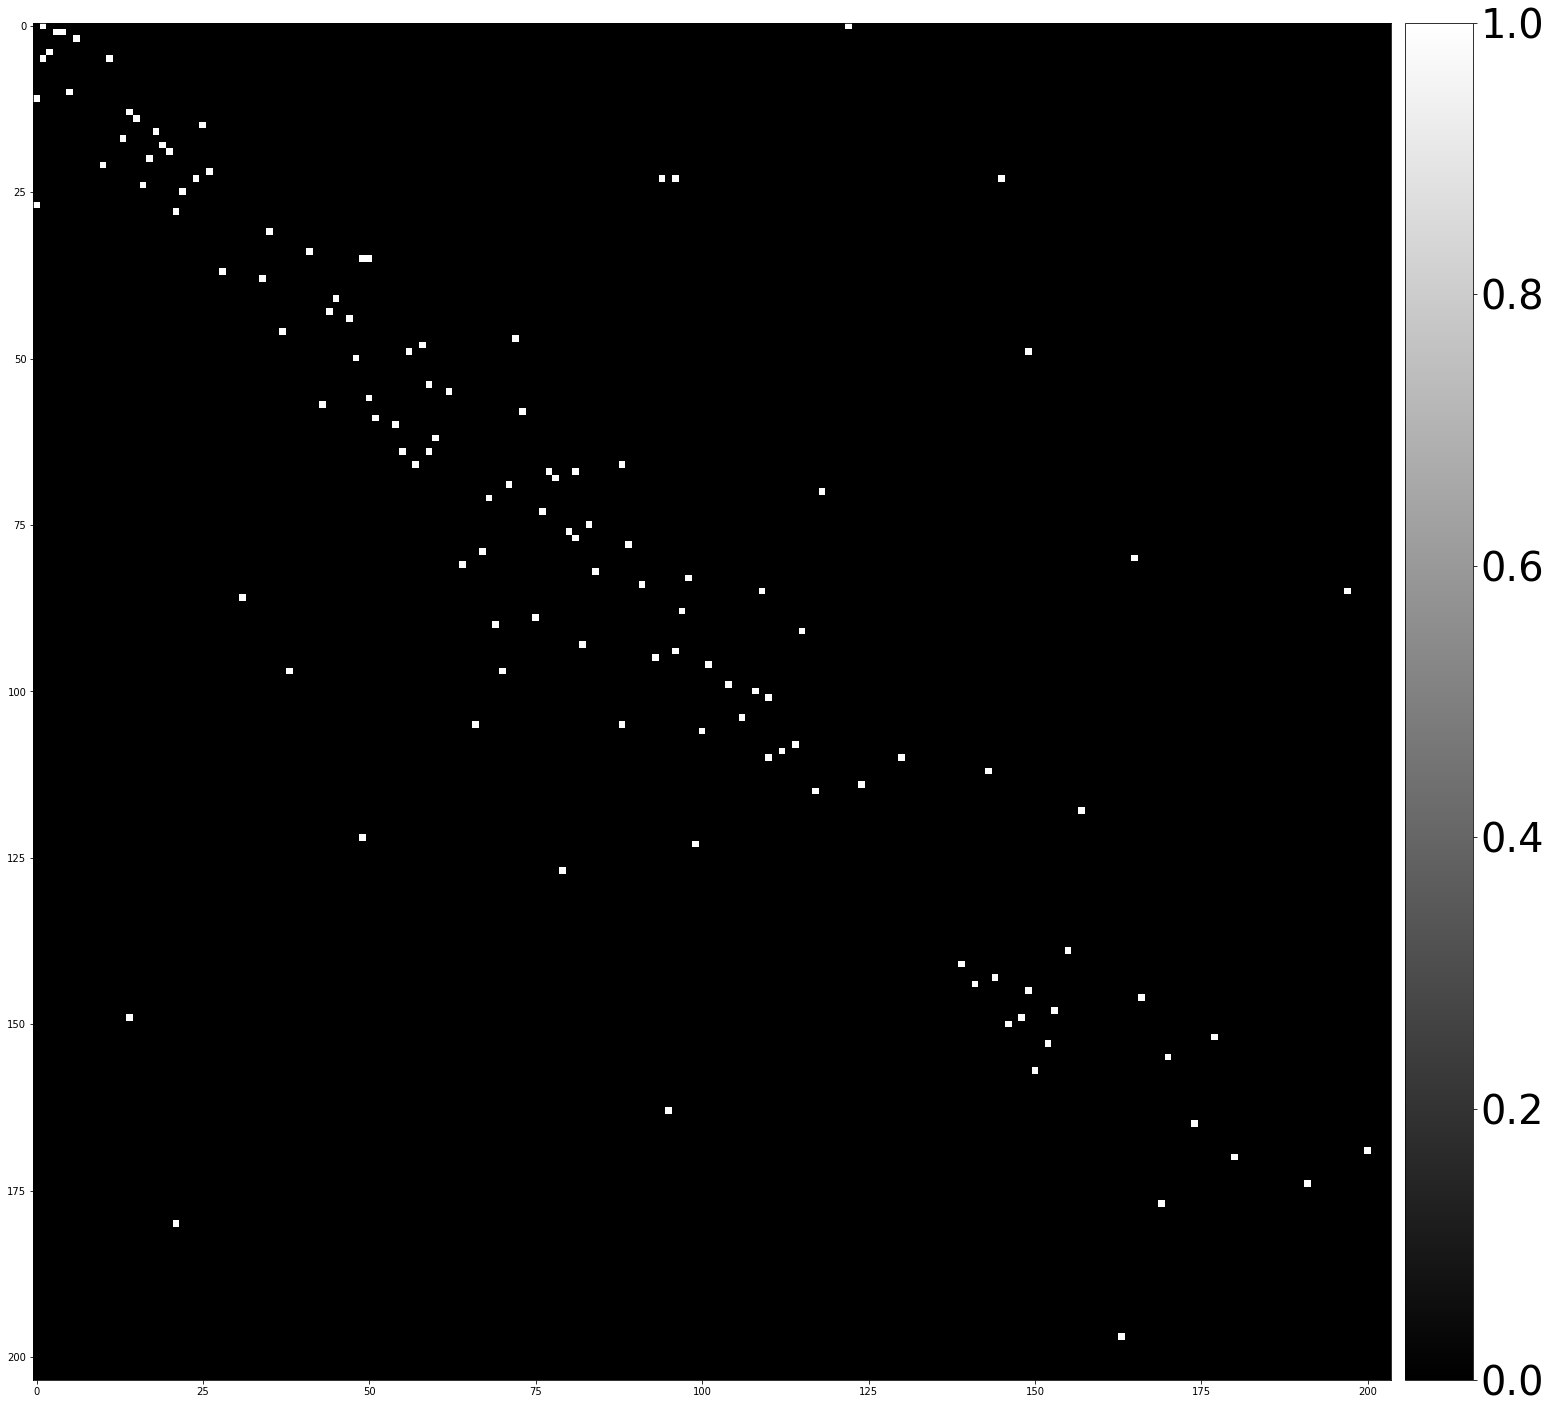

In [38]:
ca.plot_gr((answ_gr[:204, :204] > 0).astype(int))